In [1]:
import os
import json
import numpy as np
from PIL import Image
import labelme
import cv2
import shutil

cwd = os.getcwd()
source_path = os.path.join(cwd, 'dataset/sources')
image_destination = os.path.join(cwd, 'dataset/images')
print(image_destination)
json_destination = os.path.join(cwd, 'dataset/json')
contents = os.listdir(source_path)

for content in contents:
    if content.find('.json') != -1:
        number = content.split('.')[0]
        image = f'{number}.png'
        json_source = os.path.join(source_path, content)
        json_dir = os.path.join(json_destination, content)
        shutil.copy(json_source, json_dir)
        image_source = os.path.join(source_path, image)
        image_dir = os.path.join(image_destination, image)
        shutil.copy(image_source, image_dir)

print('Done')

/home/code/coding/tank/segmentation/dataset/images
Done


In [2]:
import matplotlib.pyplot as plt
from skimage.draw import polygon
from labelme.utils import shape_to_mask
import base64
import io

In [3]:
class_mapping = {
    'ignore': 0,
    'land-green': 1,
    'land-rock': 2,
    'land-dry': 3,
    'land-flat': 4,
    'water': 5,
    'sky' : 6,
    'end_of_world': 7,
    'tree': 8,
    'cannon': 9,
    'tank': 10,
    'mountain': 11,
    'house': 12,
    'rock': 13,
    'shadow': 14
}

# i = 0

for json_file in os.listdir(json_destination):
    json_path = os.path.join(json_destination, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)

    number = json_file.split('.')[0]
    image_name = f'{number}.png'
    image_path = os.path.join(image_destination, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    image = cv2.resize(image, (width, height))

    # 원본 크기의 마스크 초기화
    combined_mask = np.zeros((height, width), dtype=np.uint8)

    # shapes 처리
    for shape in data["shapes"]:
        label = shape["label"]
        class_id = class_mapping.get(label, 255)

        # Base64로 저장된 mask 데이터 디코딩
        if "mask" in shape:
            mask_data = shape["mask"]
            try:
                # Base64 디코딩
                mask_bytes = base64.b64decode(mask_data)
                
                # PNG 이미지로 로드
                mask_image = Image.open(io.BytesIO(mask_bytes))
                mask = np.array(mask_image, dtype=np.uint8)

                # 마스크 크기 확인
                # print(f"Decoded mask shape: {mask.shape}")

                # 단일 채널로 변환 (필요 시)
                if len(mask.shape) == 3:
                    mask = mask[:, :, 0]

                # 마스크가 바이너리(0 또는 1)인지 변환
                mask = (mask > 0).astype(np.uint8)

                # points에서 사각형 영역 계산
                points = shape["points"]
                x1, y1 = int(points[0][0]), int(points[0][1])
                x2, y2 = int(points[1][0]), int(points[1][1])
                mask_height, mask_width = mask.shape
                # print(f"Points: ({x1}, {y1}), ({x2}, {y2})")
                # print(f"Expected mask size: ({y2-y1}, {x2-x1})")

                # 마스크 크기와 사각형 크기 일치 확인
                expected_height = y2 - y1 + 1
                expected_width = x2 - x1 + 1
                if mask.shape != (expected_height, expected_width):
                    print(f"Mask size mismatch: expected ({expected_height}, {expected_width}), got {mask.shape}")
                    mask = cv2.resize(mask, (expected_width, expected_height), interpolation=cv2.INTER_NEAREST)

                # 원본 마스크에 할당
                region = combined_mask[y1:y2+1, x1:x2+1]
                region[mask == 1] = class_id
                combined_mask[y1:y2+1, x1:x2+1] = region


            except Exception as e:
                print(f"Error decoding mask for {label}: {e}")
                continue
        else:
            print(f"No mask data for {label}, skipping")

    mask_path = os.path.join(cwd, 'dataset/masks', json_file.replace('.json','.png'))
    Image.fromarray(combined_mask.astype(np.uint8)).save(mask_path)
    # print(f"Mask saved: {mask_path}")

    # i += 1

    # if i // 200 == 0:
    #     # 검증 및 시각화
    #     print("Unique class IDs in combined mask:", np.unique(combined_mask))
    #     plt.figure(figsize=(10, 5))
    #     plt.subplot(121)
    #     plt.imshow(image)
    #     plt.title("Original Image")
    #     plt.subplot(122)
    #     plt.imshow(combined_mask, cmap="tab20")
    #     plt.title("Segmentation Mask")
    #     plt.show()

In [4]:
import torch
from torch.utils.data import Dataset
import albumentations as A

class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path), dtype=np.int64)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return torch.tensor(image).permute(2, 0, 1).float() / 255.0, torch.tensor(mask, dtype=torch.long)

# 데이터 증강
transform = A.Compose([
    A.Resize(512, 1024),  # SegFormer 입력 크기 조정
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 데이터로더
image_dir = "dataset/images"
mask_dir = "dataset/masks"
dataset = SegDataset(image_dir, mask_dir, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

/home/code/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# 모델 로드
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-cityscapes-512-1024",
    num_labels=len(class_mapping),  # 6 (background, river, hill, tree, land-green, ignore)
    ignore_mismatched_sizes=True    # 클래스 수 불일치 무시
).to("cuda")


/home/code/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/code/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-512-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([15, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in th

In [6]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [7]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

In [14]:
import torch
from torchmetrics import JaccardIndex
import torch.nn.functional as F
from tqdm import tqdm
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# 학습 설정
num_epochs = 20
device = "cuda"

# mIoU 계산용 메트릭
jaccard = JaccardIndex(num_classes=len(class_mapping), task="multiclass", ignore_index=0).to(device)

# 학습 루프
model.train()
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    jaccard.reset()

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        # 모델 예측
        outputs = model(images).logits  # [batch_size, num_classes, H, W]
        outputs = F.interpolate(outputs, size=(512, 1024), mode='bicubic', align_corners=False)
        loss = criterion(outputs, masks)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실 및 mIoU 계산
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        jaccard.update(preds, masks)

    # 스케줄러 업데이트
    scheduler.step()

    # 에포크 결과 출력
    avg_loss = epoch_loss / len(dataloader)
    miou = jaccard.compute().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, mIoU: {miou:.4f}")

# 모델 저장
torch.save(model.state_dict(), "segformer_model.pth")

  5%|▌         | 1/20 [00:03<01:05,  3.43s/it]

Epoch 1/20, Loss: 1.9573, mIoU: 0.1106


 10%|█         | 2/20 [00:06<01:00,  3.36s/it]

Epoch 2/20, Loss: 1.9479, mIoU: 0.1127


 15%|█▌        | 3/20 [00:13<01:19,  4.69s/it]

Epoch 3/20, Loss: 1.9609, mIoU: 0.1084


 20%|██        | 4/20 [00:16<01:06,  4.15s/it]

Epoch 4/20, Loss: 1.9470, mIoU: 0.1126


 25%|██▌       | 5/20 [00:19<00:57,  3.86s/it]

Epoch 5/20, Loss: 1.9374, mIoU: 0.1129


 30%|███       | 6/20 [00:23<00:51,  3.69s/it]

Epoch 6/20, Loss: 1.9406, mIoU: 0.1122


 35%|███▌      | 7/20 [00:26<00:46,  3.58s/it]

Epoch 7/20, Loss: 1.9048, mIoU: 0.1143


 40%|████      | 8/20 [00:29<00:42,  3.50s/it]

Epoch 8/20, Loss: 1.8994, mIoU: 0.1207


 45%|████▌     | 9/20 [00:33<00:38,  3.46s/it]

Epoch 9/20, Loss: 1.8695, mIoU: 0.1196


 50%|█████     | 10/20 [00:36<00:34,  3.42s/it]

Epoch 10/20, Loss: 1.8911, mIoU: 0.1164


 55%|█████▌    | 11/20 [00:39<00:30,  3.40s/it]

Epoch 11/20, Loss: 1.8532, mIoU: 0.1202


 60%|██████    | 12/20 [00:46<00:34,  4.27s/it]

Epoch 12/20, Loss: 1.8214, mIoU: 0.1243


 65%|██████▌   | 13/20 [00:49<00:27,  3.98s/it]

Epoch 13/20, Loss: 1.8148, mIoU: 0.1248


 70%|███████   | 14/20 [00:52<00:22,  3.78s/it]

Epoch 14/20, Loss: 1.8280, mIoU: 0.1170


 75%|███████▌  | 15/20 [00:56<00:18,  3.64s/it]

Epoch 15/20, Loss: 1.7557, mIoU: 0.1385


 80%|████████  | 16/20 [00:59<00:14,  3.54s/it]

Epoch 16/20, Loss: 1.7632, mIoU: 0.1366


 85%|████████▌ | 17/20 [01:02<00:10,  3.47s/it]

Epoch 17/20, Loss: 1.7505, mIoU: 0.1242


 90%|█████████ | 18/20 [01:05<00:06,  3.44s/it]

Epoch 18/20, Loss: 1.6879, mIoU: 0.1440


 95%|█████████▌| 19/20 [01:09<00:03,  3.41s/it]

Epoch 19/20, Loss: 1.6267, mIoU: 0.1635


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]

Epoch 20/20, Loss: 1.6557, mIoU: 0.1503


In [15]:
from torch.utils.data import Subset
import numpy as np

# 데이터셋 분할 (80% 훈련, 20% 검증)
indices = np.arange(len(dataset))
np.random.shuffle(indices)
train_size = int(0.8 * len(dataset))
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

Validation mIoU: 0.2413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.0019693463].


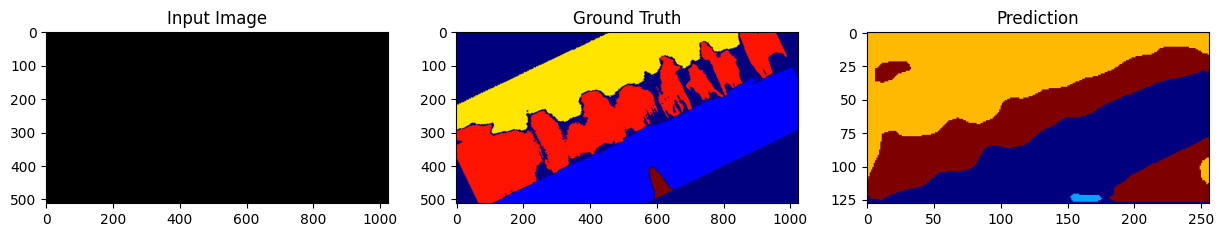

In [16]:
model.eval()
jaccard.reset()

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images).logits
        outputs = F.interpolate(outputs, size=(512, 1024), mode="bicubic", align_corners=False)
        preds = torch.argmax(outputs, dim=1)
        jaccard.update(preds, masks)

print(f"Validation mIoU: {jaccard.compute().item():.4f}")

# 시각화
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    outputs = model(images).logits
    preds = torch.argmax(outputs, dim=1)

# 첫 번째 샘플 시각화
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
plt.title("Input Image")
plt.subplot(132)
plt.imshow(masks[0].cpu().numpy(), cmap="jet")
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(preds[0].cpu().numpy(), cmap="jet")
plt.title("Prediction")
plt.show()